In [6]:
import os
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import random
import xarray as xr
import pickle
import scipy.stats as st
from scipy.stats import gaussian_kde
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'

In [2]:
import os
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm   # needed for sample_prior_predictive

param_list = [
    "mu_alpha", "mu_epsilon", "mu_beta",
    "sigma_alpha", "sigma_epsilon", "sigma_beta",
    "sigma_Q", "sigma_S", "sigma_W",
    "alpha", "epsilon", "beta"
]

def plot_priors_posteriors(trace, model, basin_name, tdim, plot_dir):
    fig, axes = plt.subplots(3, 4, figsize=(24, 14))
    axes = axes.flatten()

    # Draw samples from priors
    with model:
        prior_pred = pm.sample_prior_predictive(samples=1000, random_seed=42)

    for i, param in enumerate(param_list):
        ax = axes[i]
        try:
            prior_samples = prior_pred.prior[param].values.flatten()
            posterior_samples = trace.posterior[param].values.flatten()
        except KeyError:
            continue

        # Plot prior histogram
        ax.hist(prior_samples, bins=30, density=True, alpha=0.3,
                color="grey", label="Prior")

        # Plot posterior KDE
        az.plot_kde(posterior_samples, ax=ax, label="Posterior",
                    plot_kwargs={"color": "blue"})

        # Posterior mean
        mean_val = np.mean(posterior_samples)
        ax.axvline(mean_val, color="k", linestyle="-", linewidth=1, label="Mean")
        ax.text(mean_val, ax.get_ylim()[1] * 0.75, f"{mean_val:.2f}",
                ha="center", fontsize=15, fontweight="bold",
                backgroundcolor="white", alpha=0.7)

        # 90% HDI
        hdi = az.hdi(posterior_samples, hdi_prob=0.9)
        ax.axvline(hdi[0], color="red", linestyle="--", linewidth=1)
        ax.axvline(hdi[1], color="red", linestyle="--", linewidth=1)

        ax.set_title(param, fontsize=15, fontweight="bold")
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(14)
            label.set_fontweight("bold")
        ax.legend(loc="best", prop={"size": 13, "weight": "bold"})

    fig.suptitle(
        f"Prior vs Posterior Distributions - Bayesian Hierarchical Model for {basin_name} ({tdim})",
        fontsize=16, fontweight="bold", y=1
    )
    plt.subplots_adjust(left=0.03, right=0.95, top=0.95, bottom=0.04,
                        wspace=0.2, hspace=0.22)

    
    fig.savefig(f"{plot_dir}/1 {basin_name}_dist_BH_{tdim}.png", dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {plot_dir}")


In [3]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def compute_bic(idata, log_Q_obs):
    """
    Compute Bayesian Information Criterion (BIC) for model fit.

    Args:
        idata: ArviZ InferenceData object (posterior samples + log-likelihood)
        log_Q_obs: observed log(Q) values [T x S]

    Returns:
        BIC value (float)
    """
    n = log_Q_obs.size  # total number of observations

    # Total log-likelihood: sum over all sites & times, then average across posterior draws
    log_lik = (
        idata.log_likelihood["log_Q_obs"]
        .sum(dim=("log_Q_obs_dim_0", "log_Q_obs_dim_1"))
        .mean()
        .item()
    )

    # Number of estimated parameters = product of shapes of each parameter
    # Exclude latent arrays like Q_pred (we want free parameters only)
    k = 0
    for var, arr in idata.posterior.items():
        if var not in ["Q_pred"]:  # skip latent prediction arrays
            k += np.prod(arr.shape[2:])  # (chain, draw, ...) → count only parameter dims

    # Standard BIC formula
    bic = k * np.log(n) - 2 * log_lik
    return bic


# NSE, KGE, and RMSE helper functions
def nse(obs, pred):
    return 1 - np.sum((obs - pred)**2) / np.sum((obs - np.mean(obs))**2)

def kge(obs, pred):
    from scipy.stats import pearsonr
    r = pearsonr(obs, pred)[0]
    alpha = np.std(pred) / np.std(obs)
    beta = np.mean(pred) / np.mean(obs)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def rmse(obs, pred):
    """Root Mean Square Error"""
    return np.sqrt(mean_squared_error(obs, pred))


In [5]:
# f1 legend, f2 subplot title, axes labels, f3 suptitle

# Basin-specific settings (updated with bottom margin = yb, top margin = yt, and left margin xl=0)
BASIN_SETTINGS = {
    "Brahmani-Baitarani": {"f1": 11, "f2": 13,   "f3": 13.5, "yb": 0.06, "yt": 1, "ys": 1.07, "layout": (2, 3), "xl": 0},
    "Cauvery":            {"f1": 11, "f2": 12.3, "f3": 14,   "yb": 0.05, "yt": 1, "ys": 1.05, "layout": (3, 3), "xl": 0},
    "EFRS":               {"f1": 9,  "f2": 12,   "f3": 12,   "yb": 0.10, "yt": 1, "ys": 1.12, "layout": (1, 3), "xl": -0.02},
    "Godavari":           {"f1": 11, "f2": 12,   "f3": 12,   "yb": 0.05, "yt": 1, "ys": 1.05, "layout": (3, 3), "xl": 0},
    "Krishna":            {"f1": 11, "f2": 13,   "f3": 15,   "yb": 0.05, "yt": 1, "ys": 1.05, "layout": (3, 4), "xl": 0},
    "Mahanadi":           {"f1": 11, "f2": 13,   "f3": 16,   "yb": 0.05, "yt": 1, "ys": 1.05, "layout": (4, 4), "xl": 0},
    "Mahi":               {"f1": 9,  "f2": 12,   "f3": 12,   "yb": 0.10, "yt": 1, "ys": 1.12, "layout": (1, 3), "xl": -0.02},
    "Narmada":            {"f1": 11, "f2": 12,   "f3": 15,   "yb": 0.05, "yt": 1, "ys": 1.05, "layout": (3, 4), "xl": 0},
    "Subernarekha":       {"f1": 9,  "f2": 11.5, "f3": 12,   "yb": 0.10, "yt": 1, "ys": 1.12, "layout": (1, 3), "xl": -0.02},
    "WFRS":               {"f1": 11, "f2": 11,   "f3": 14,   "yb": 0.05, "yt": 1, "ys": 1.05, "layout": (3, 3), "xl": 0},
}


def plot_qpred_qobs_timeseries(
    trace, basin_name, station_labels, Q_obs_model, Q_pred_mean,
    Q_pred_samples, metrics_basin, plot_dir
):
    """
    Plot Q_obs vs Q_pred time series with 90% credible interval shading,
    using site + basin metrics from Excel (metrics_basin).
    """
    # 90% CI from trace
    Q_pred_p5 = np.percentile(Q_pred_samples, 5, axis=0)
    Q_pred_p95 = np.percentile(Q_pred_samples, 95, axis=0)

    # Plot settings
    settings = BASIN_SETTINGS.get(basin_name)
    f1, f2, f3 = settings["f1"], settings["f2"], settings["f3"]
    nrows, ncols = settings["layout"]
    y_bottom, y_top, y_s = settings["yb"], settings["yt"], settings["ys"]
    xl = settings["xl"]

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axes = np.atleast_1d(axes).flatten()
    S = Q_obs_model.shape[1]

    for i, ax in enumerate(axes[:S]):
        t = np.arange(Q_obs_model.shape[0])
        Qo = Q_obs_model[:, i]
        Qp = Q_pred_mean[:, i]

        # Match SubBasin row
        site_id = station_labels[i]
        if site_id not in metrics_basin.index:
            continue
        row = metrics_basin.loc[site_id]

        eps_val = row["Elasticity_epsilon (ε_s)"]
        r2, nse_val, rmse_val, kge_val = row["R²"], row["NSE"], row["RMSE"], row["KGE"]

        # Plot obs + pred + CI
        ax.plot(t, Qo, label="Q_obs", color="red", lw=1)
        ax.plot(t, Qp, label="Q_pred (Mean)", color="blue", lw=1.2, alpha=0.8)
        ax.fill_between(t, Q_pred_p5[:, i], Q_pred_p95[:, i], color="blue", alpha=0.3, label="90% CI")

        ax.set_title(
            f"{site_id} | ε_s={eps_val:.2f} | R²={r2:.2f} | NSE={nse_val:.2f} | "
            f"KGE={kge_val:.2f} | RMSE={rmse_val:.0f}",
            fontsize=f2-0.8, fontweight="bold"
        )
        ax.grid(True, linestyle="--", alpha=0.5)
        leg = ax.legend(fontsize=f1, loc="upper right")
        for text in leg.get_texts():
            text.set_fontweight("bold")
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(f2)
            label.set_fontweight("bold")

    # Remove unused axes
    for j in range(S, len(axes)):
        fig.delaxes(axes[j])

    # Basin-wide values (take first row)
    BIC_val = metrics_basin["BIC"].iloc[0]
    mu_eps_mean = metrics_basin["Basin_mean_epsilon (μ_ε)"].iloc[0]

    fig.suptitle(
        f"Bayesian Hierarchical Model - {basin_name} | BIC={BIC_val:.2f} | μ_ε={mu_eps_mean:.2f} ({tdim})",
        fontsize=f3, fontweight="bold", y=y_s
    )
    fig.text(0.5, 0, "Time (years)", ha="center", fontsize=f2, fontweight="bold")
    fig.text(xl, 0.5, "Streamflow (mm/day/year)", va="center", rotation="vertical",
             fontsize=f2, fontweight="bold")

    plt.subplots_adjust(left=xl+0.04, right=1, top=y_top, bottom=y_bottom,
                        wspace=0.15, hspace=0.2)
    fig.savefig(f"{plot_dir}/2 {basin_name}_QQ_BH_{tdim}.png", dpi=300, bbox_inches="tight")
    plt.show()


In [5]:
        # # ------------------- HIERARCHICAL PRECISIONS -------------------
        # tau_alpha   = pm.Gamma("tau_alpha", alpha=2, beta=1)
        # tau_epsilon = pm.Gamma("tau_epsilon", alpha=2, beta=1)
        # tau_beta    = pm.Gamma("tau_beta", alpha=2, beta=1)

        # # Convert to standard deviations
        # sigma_alpha   = pm.Deterministic("sigma_alpha", 1 / pm.math.sqrt(tau_alpha))
        # sigma_epsilon = pm.Deterministic("sigma_epsilon", 1 / pm.math.sqrt(tau_epsilon))
        # sigma_beta    = pm.Deterministic("sigma_beta", 1 / pm.math.sqrt(tau_beta))

In [6]:
import numpy as np
import pymc as pm
import scipy.stats as st

#---------- Model ----------
def run_bayesian_model(log_Q_obs, log_P, log_ET):
    T, S = log_Q_obs.shape

    with pm.Model() as model:

        # Global means
        mu_alpha = pm.TruncatedNormal("mu_alpha", mu=0, sigma=2, lower=0)
        mu_epsilon = pm.Uniform("mu_epsilon", lower=0, upper=4)
        mu_beta = pm.Normal("mu_beta", mu=0, sigma=2)

        # -------- HIERARCHICAL SCALES --------
        sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)
        sigma_epsilon = pm.HalfNormal("sigma_epsilon", sigma=1)
        sigma_beta = pm.HalfNormal("sigma_beta", sigma=1)

        # ------------------- STATION-LEVEL PARAMETERS -------------------
        alpha = pm.TruncatedNormal("alpha", mu=mu_alpha, sigma=sigma_alpha, lower=0, shape=S)
        epsilon = pm.TruncatedNormal("epsilon", mu=mu_epsilon, sigma=sigma_epsilon, lower=0, upper=4, shape=S)
        beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=S)
        
        # -------- NOISE --------
        sigma_Q = pm.HalfStudentT("sigma_Q", nu=4, sigma=1)
        sigma_S = pm.HalfStudentT("sigma_S", nu=4, sigma=1)
        sigma_W = pm.HalfStudentT("sigma_W", nu=4, sigma=1)

        # ------------------- Process equations -------------------
        delta_S = pm.Normal("delta_S", mu=beta[None, :] * (log_P - log_ET), sigma=sigma_S, shape=(T, S))
        
        W = pm.Normal("W", mu=0, sigma=sigma_W, shape=(T, S))
     
        # Correct natural streamflow equation: log(alpha) + epsilon*logP
        log_Q_nat = pm.Deterministic("log_Q_nat", alpha[None, :] + epsilon[None, :] * log_P)

        log_Q_pred = pm.Deterministic("log_Q_pred", log_Q_nat + delta_S - W)
        Q_pred = pm.Deterministic("Q_pred", pm.math.exp(log_Q_pred))

        # Observation model
        pm.Normal("log_Q_obs", mu=log_Q_pred, sigma=sigma_Q, observed=log_Q_obs)

        # Sampling
        trace = pm.sample(1000, tune=100, chains=3, target_accept=0.9,
                          return_inferencedata=True, random_seed=42, idata_kwargs={"log_likelihood": True})

    return model, trace



In [7]:
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
qdata_dir = os.path.join(data_dir, "Q")
plot_dir = os.path.join(data_dir, "BH")
os.makedirs(plot_dir, exist_ok=True)

In [8]:
plot_dir

'C:\\Users\\User\\OneDrive - The University of Melbourne\\1 Poornima_Research_Work\\5 Elasticity\\BH'

In [9]:
###########################      Annual sum analysis


=== Processing Basin: Brahmani-Baitarani ===


Initializing NUTS using jitter+adapt_diag...
C:\Users\User\.conda\envs\bayes\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu_alpha, mu_epsilon, mu_beta, sigma_alpha, sigma_epsilon, sigma_beta, alpha, epsilon, beta, sigma_Q, sigma_S, sigma_W, delta_S, W]


Output()

Sampling 3 chains for 100 tune and 1_000 draw iterations (300 + 3_000 draws total) took 17 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Trace saved: C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\traces\BH_Brahmani-Baitarani_Annual_sum.pkl


Sampling: [W, alpha, beta, delta_S, epsilon, log_Q_obs, mu_alpha, mu_beta, mu_epsilon, sigma_Q, sigma_S, sigma_W, sigma_alpha, sigma_beta, sigma_epsilon]


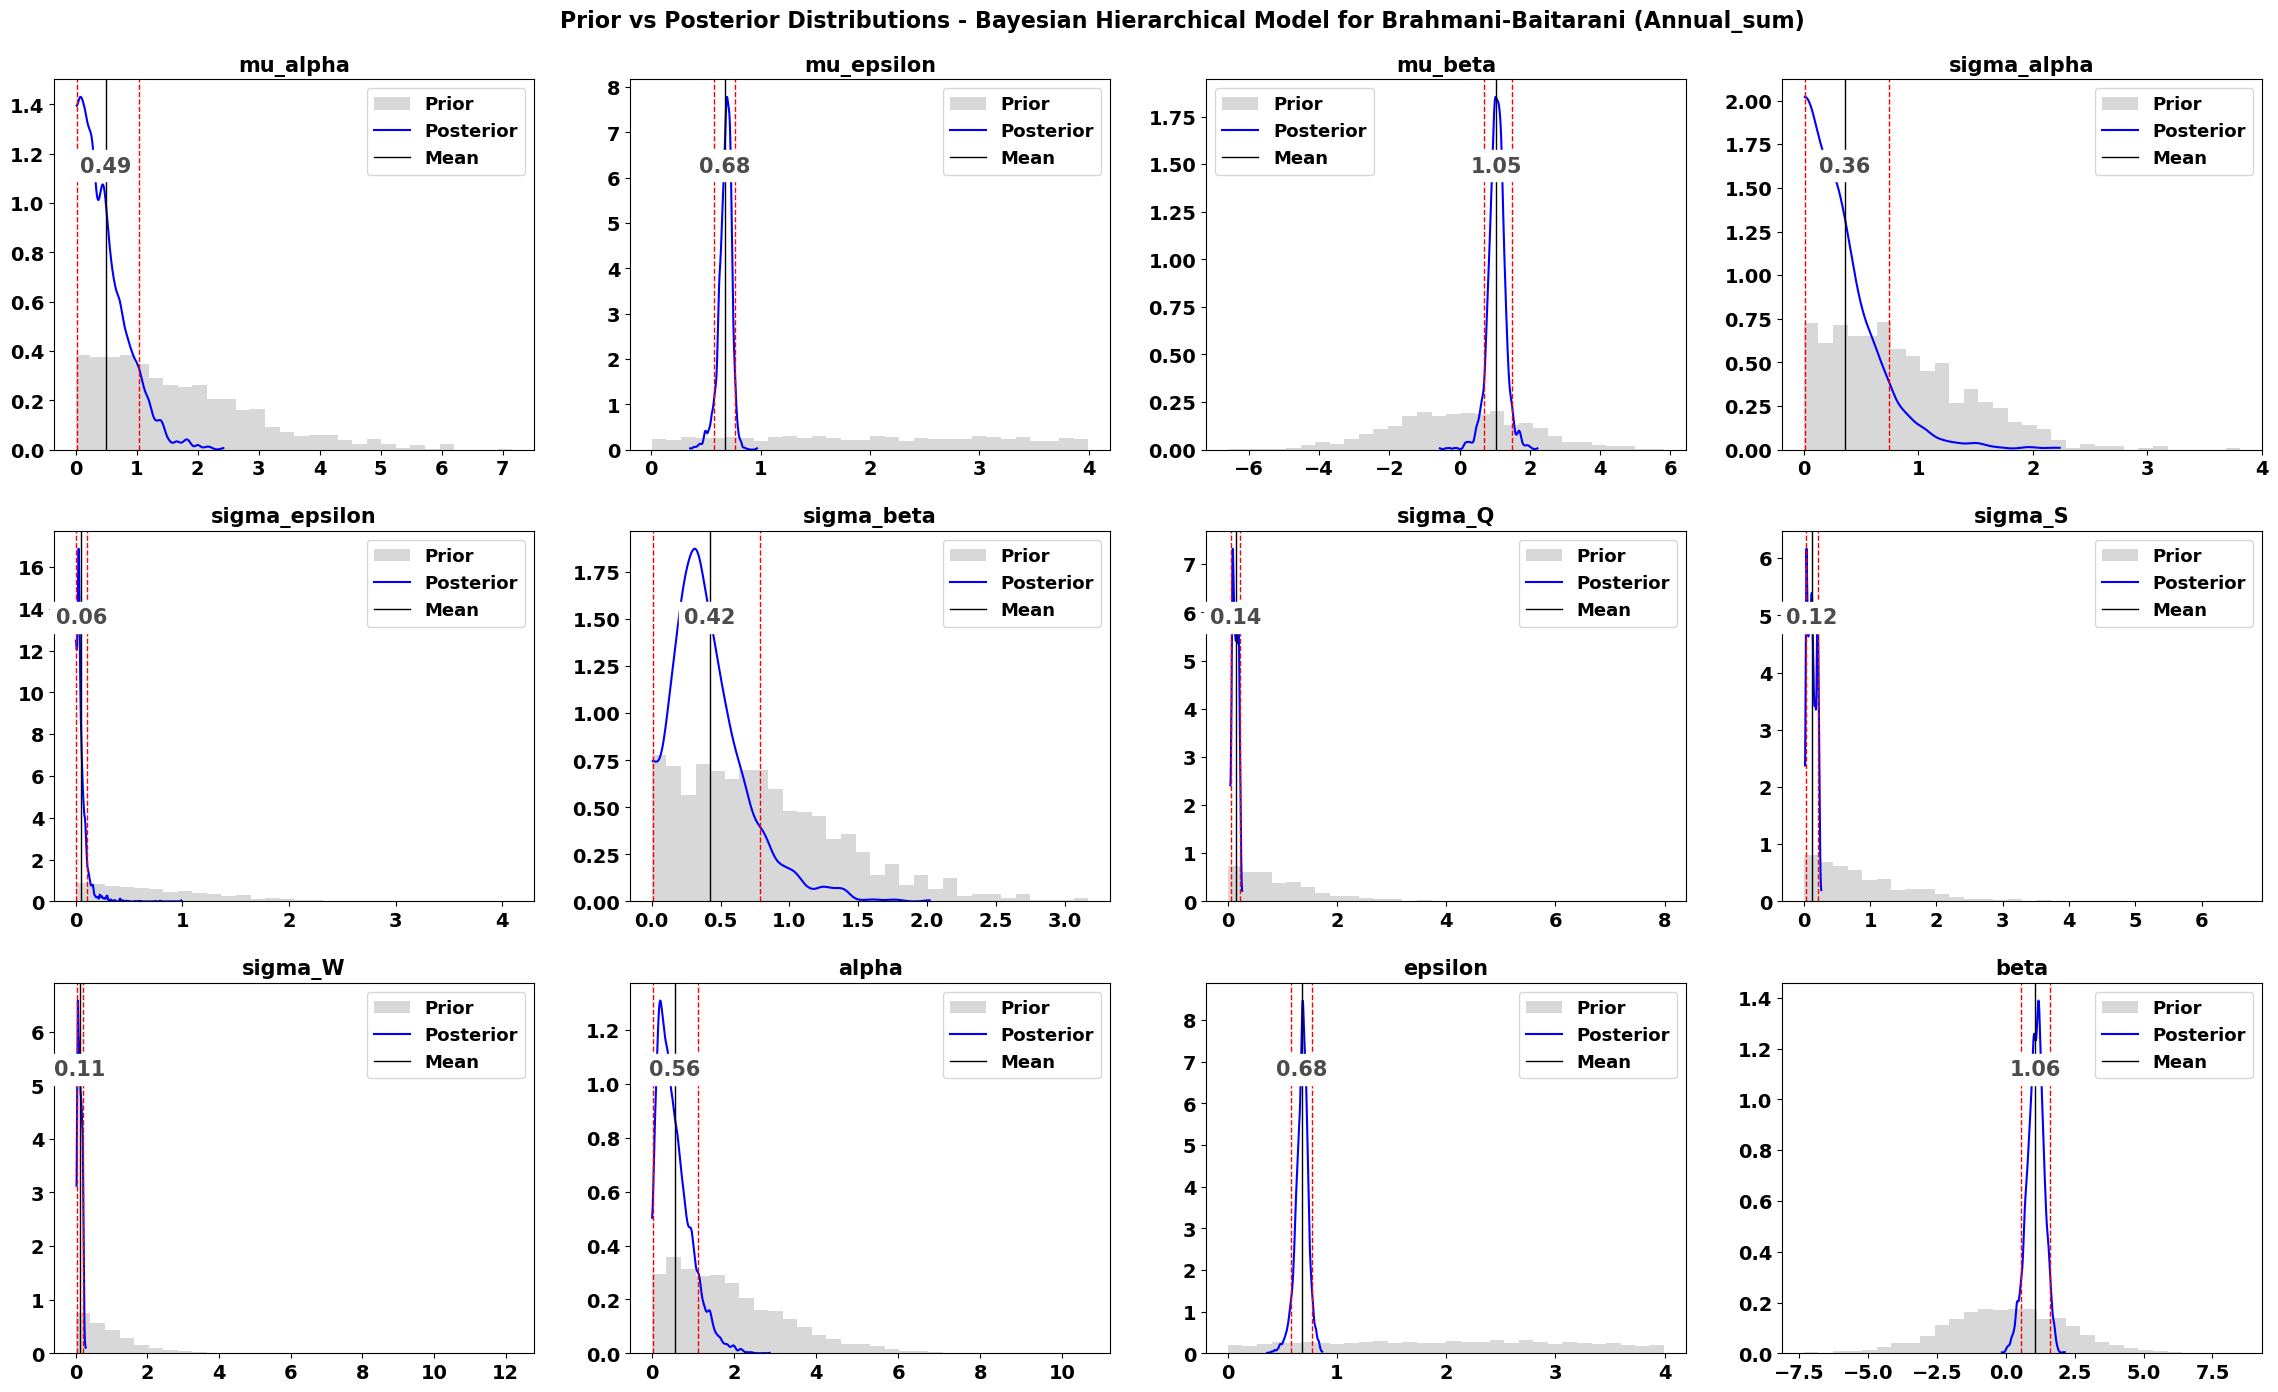

Saved: C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\BH


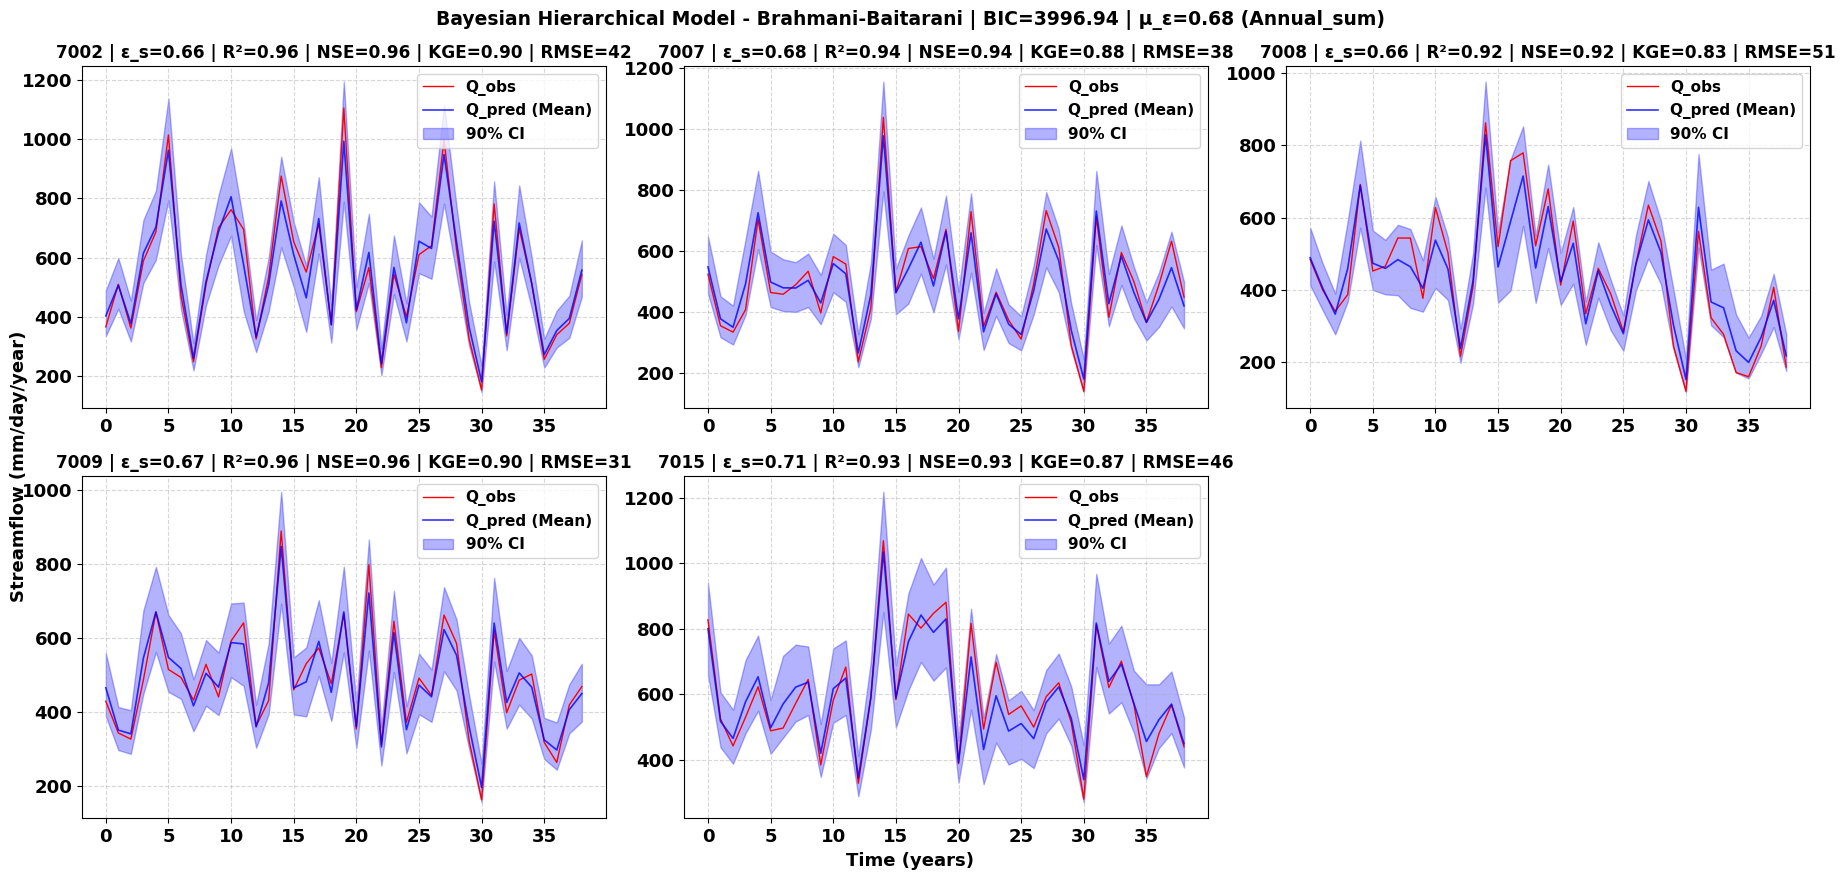


=== Processing Basin: Cauvery ===


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu_alpha, mu_epsilon, mu_beta, sigma_alpha, sigma_epsilon, sigma_beta, alpha, epsilon, beta, sigma_Q, sigma_S, sigma_W, delta_S, W]


Output()

Sampling 3 chains for 100 tune and 1_000 draw iterations (300 + 3_000 draws total) took 20 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [W, alpha, beta, delta_S, epsilon, log_Q_obs, mu_alpha, mu_beta, mu_epsilon, sigma_Q, sigma_S, sigma_W, sigma_alpha, sigma_beta, sigma_epsilon]


Trace saved: C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\traces\BH_Cauvery_Annual_sum.pkl


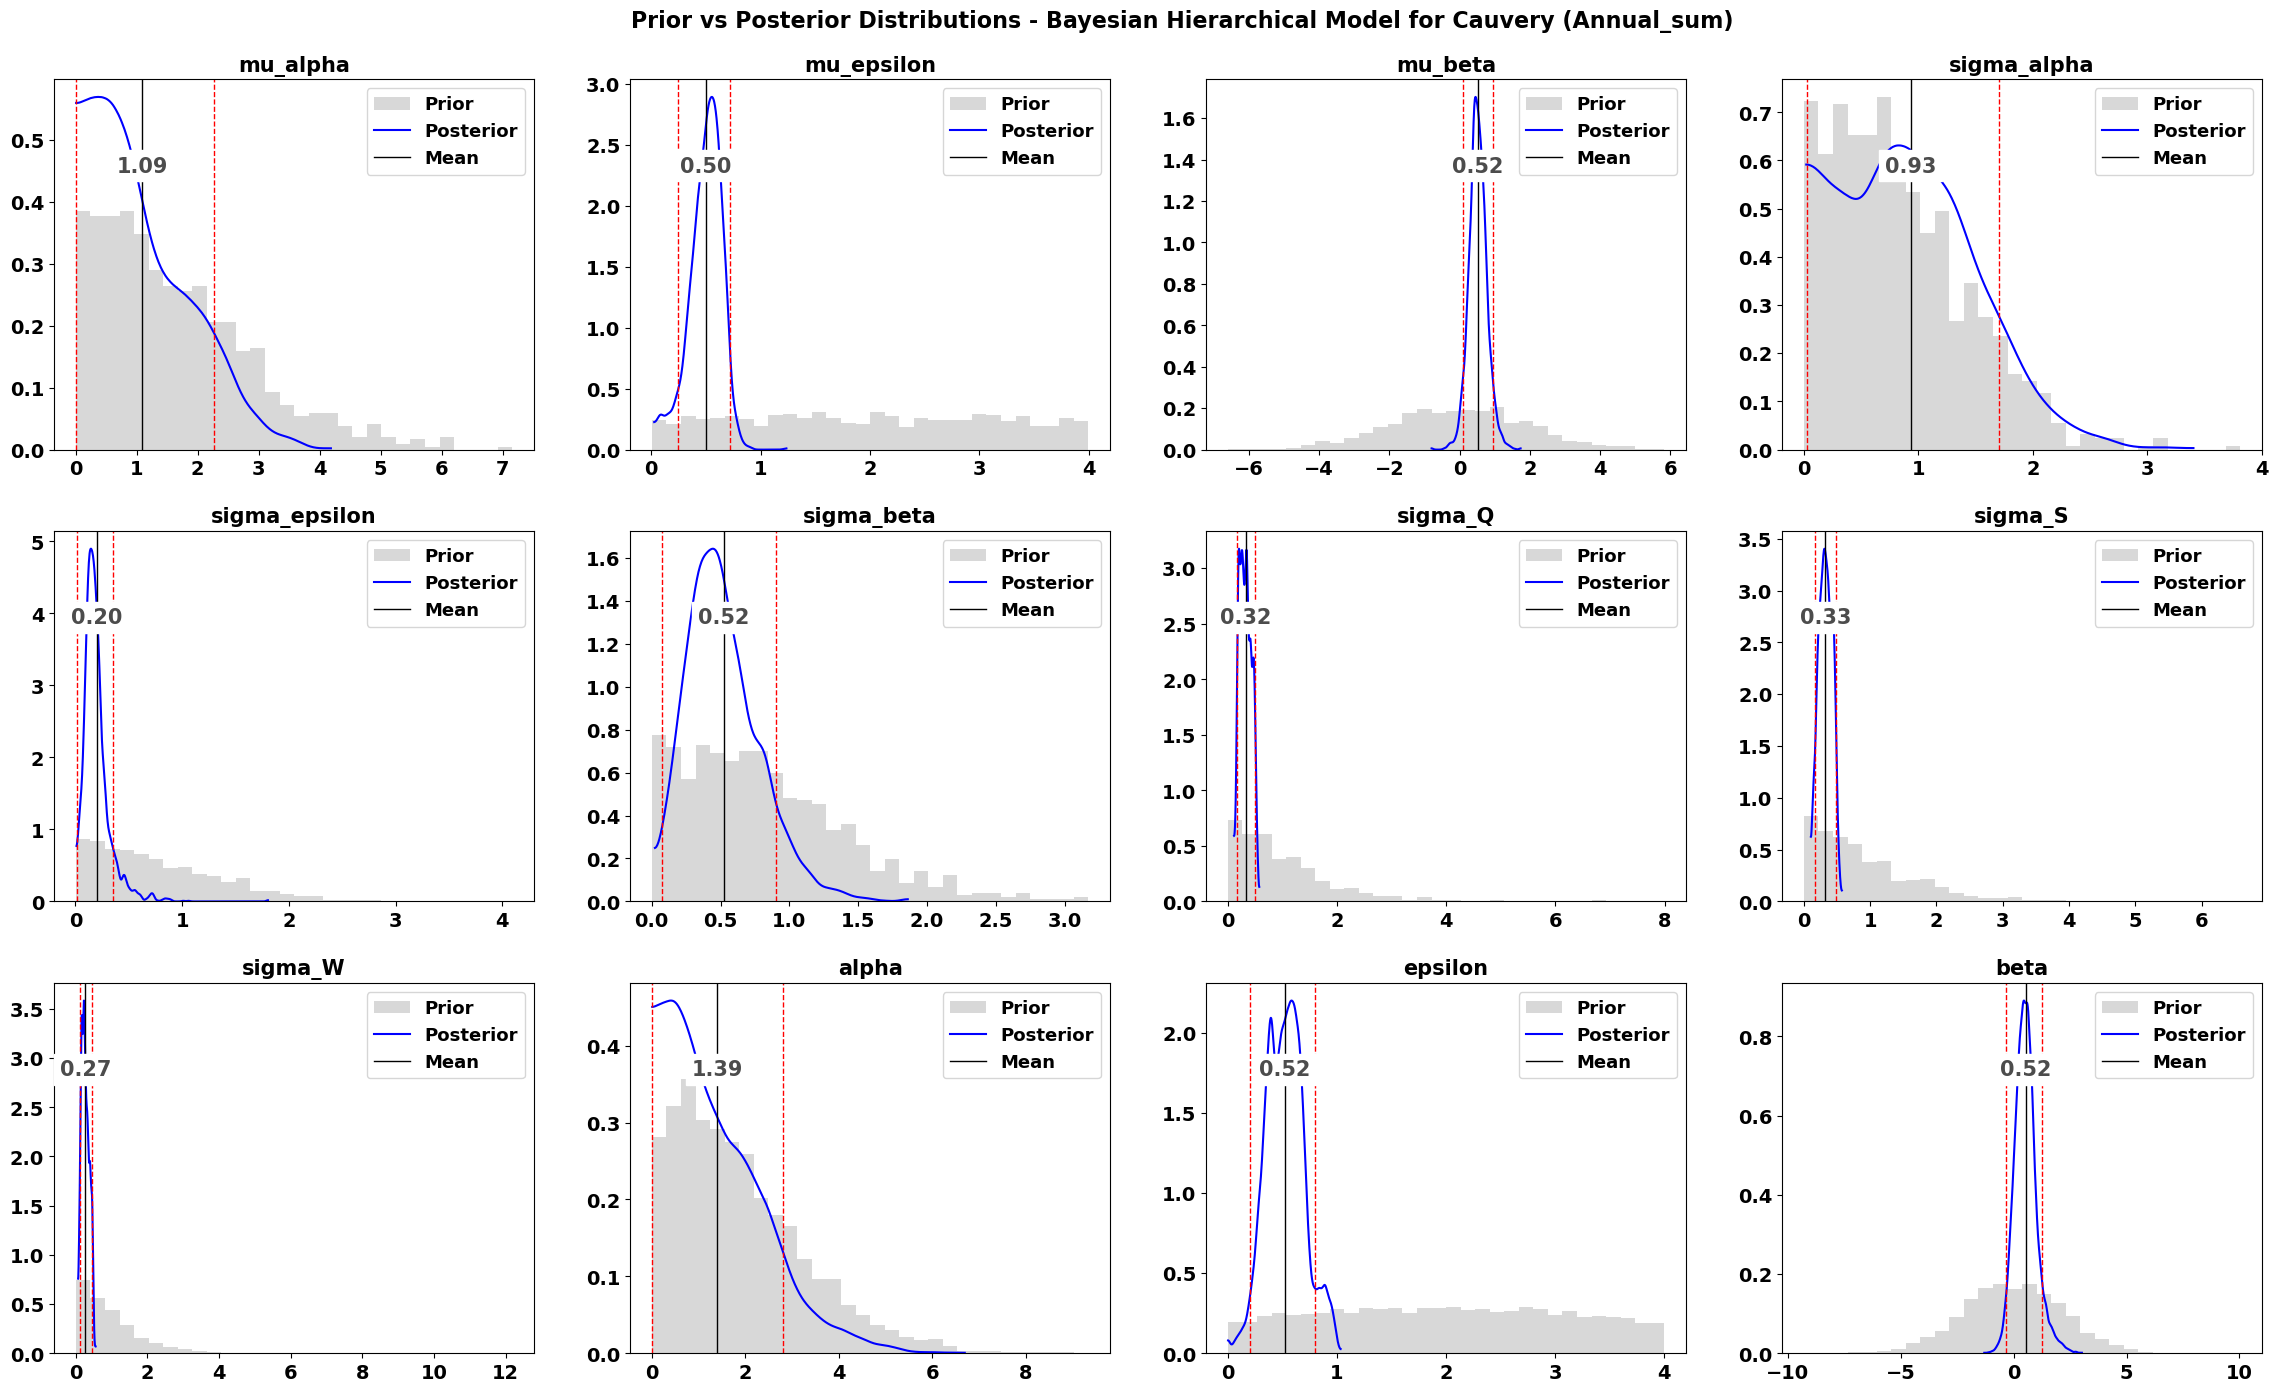

Saved: C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity\BH


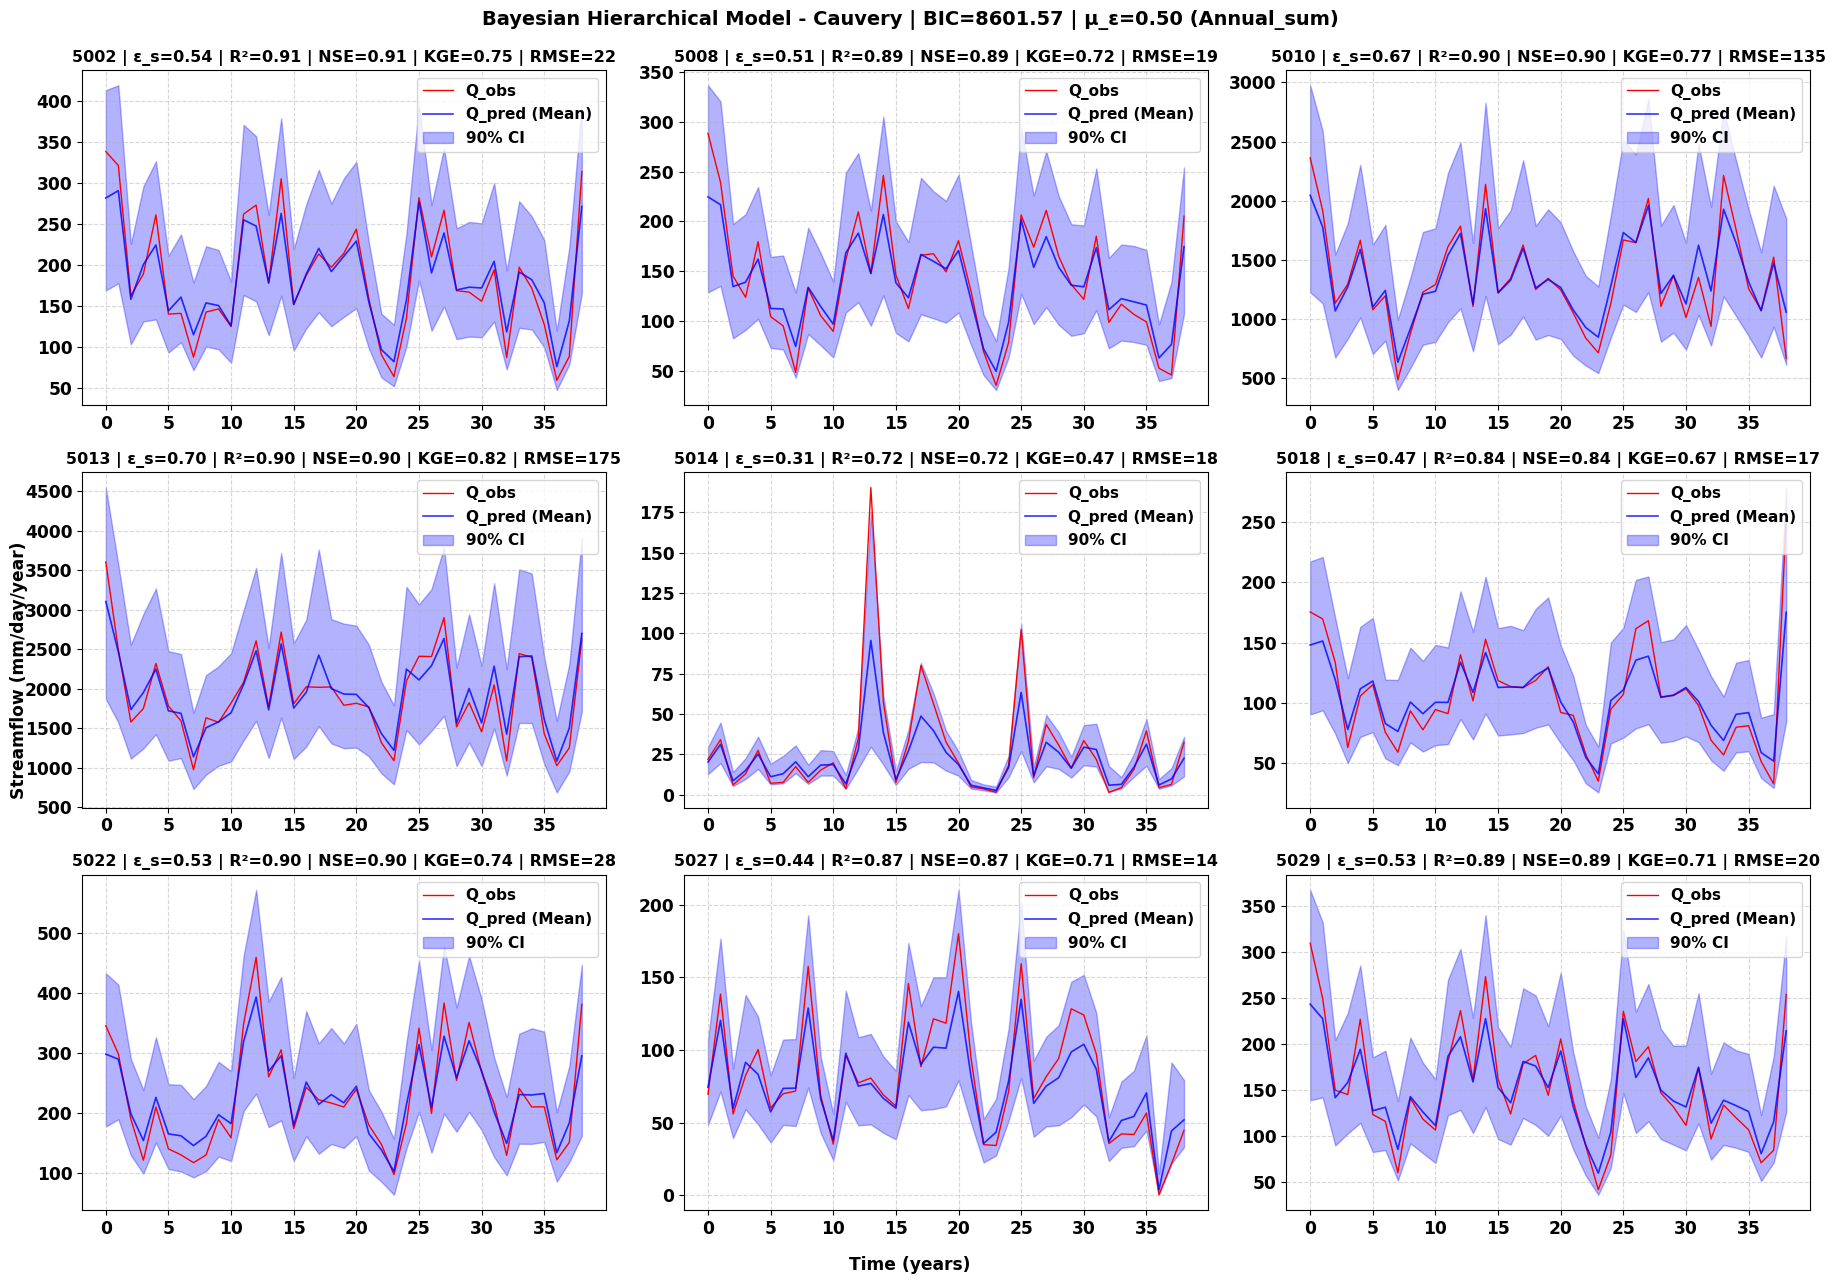


=== Processing Basin: EFRS ===


Initializing NUTS using jitter+adapt_diag...

KeyboardInterrupt


KeyboardInterrupt



In [8]:
# ===============================================
# INTEGRATED SCRIPT: BAYESIAN HIERARCHICAL MODEL
# Run model, save trace, compute metrics, and plot
# ===============================================

import os
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pickle
import random
from sklearn.metrics import r2_score

# ---------------- SETUP ----------------
model_name = "Bayesian Hierarchical model"
tdim = "Annual_sum"
C = 1e-6  # Small constant to avoid log(0)
random.seed(42)
np.random.seed(42)

# Load metadata
summary_df = pd.read_excel(os.path.join(data_dir, "Basin_Station_Summary.xlsx"), sheet_name="Asum_sites")
basins = summary_df['Basin'].unique()

# Initialize results storage
results_list = []

# ---------- FUNCTION: Load basin data ----------
def load_basin_data(basin_name):
    """
    Loads annual streamflow (Q), precipitation (P), and evapotranspiration (AET)
    data for all stations in the given basin.

    Returns:
        all_Q, all_P, all_AET (arrays): log-transformed values [station x time]
        labels (list): station Gauge IDs
    """
    basin_df = summary_df[summary_df['Basin'] == basin_name]
    all_Q, all_P, all_AET, labels = [], [], [], []

    for _, row in basin_df.iterrows():
        file_path = os.path.join(qdata_dir, f"{row['Basin']}.xlsx")
        try:
            data = pd.read_excel(file_path, sheet_name=str(row['Gauge_ID']))
            if all(col in data.columns for col in ['Annual_Q', 'Annual_P', 'Annual_AET']):
                Q = data['Annual_Q'].dropna().values
                P = data['Annual_P'].dropna().values
                AET = data['Annual_AET'].dropna().values
                min_len = min(len(Q), len(P), len(AET))

                all_Q.append(np.log(Q[:min_len] + C))
                all_P.append(np.log(P[:min_len] + C))
                all_AET.append(np.log(AET[:min_len] + C))
                labels.append(row['Gauge_ID'])

        except Exception as e:
            print(f"Failed for {file_path} | Gauge {row['Gauge_ID']} due to: {e}")

    return np.array(all_Q), np.array(all_P), np.array(all_AET), labels


# ---------- MAIN LOOP ----------
for basin_name in basins:
    print(f"\n=== Processing Basin: {basin_name} ===")
    log_Q_obs, log_P, log_ET, station_labels = load_basin_data(basin_name)
    if log_Q_obs.size == 0:
        print(f"Skipping {basin_name}: No valid data.")
        continue

    log_Q_obs, log_P, log_ET = log_Q_obs.T, log_P.T, log_ET.T

    # ---- Fit Bayesian model ----
    model, trace = run_bayesian_model(log_Q_obs, log_P, log_ET)

    # ---- Save trace ----
    trace_path = os.path.join(data_dir, f"traces\\BH_{basin_name}_{tdim}.pkl")
    os.makedirs(os.path.dirname(trace_path), exist_ok=True)
    with open(trace_path, "wb") as f:
        pickle.dump(trace, f)
    print(f"Trace saved: {trace_path}")

    # ---- Compute results ----
    BIC_val = compute_bic(trace, log_Q_obs)
    Q_obs = np.exp(log_Q_obs)
    Q_pred = trace.posterior["Q_pred"].values
    Q_pred_samples = Q_pred.reshape(-1, *Q_pred.shape[2:])
    Q_pred_mean = np.mean(Q_pred_samples, axis=0)

    site_eps = trace.posterior['epsilon'].mean(dim=("chain", "draw")).values
    site_beta = trace.posterior['beta'].mean(dim=("chain", "draw")).values
    mu_eps_mean = trace.posterior['mu_epsilon'].mean(dim=("chain", "draw")).item()
    mu_beta_mean = trace.posterior['mu_beta'].mean(dim=("chain", "draw")).item()

    S_model = Q_pred_mean.shape[1]
    Q_obs_model = Q_obs[:, :S_model]

    for i in range(S_model):
        Qo, Qp = Q_obs_model[:, i], Q_pred_mean[:, i]
        results_list.append({
            "Basin": basin_name,
            "SubBasin": station_labels[i],
            "Elasticity_beta (β_s)": site_beta[i],
            "Elasticity_epsilon (ε_s)": site_eps[i],
            "R²": r2_score(Qo, Qp),
            "NSE": nse(Qo, Qp),
            "RMSE": rmse(Qo, Qp),
            "KGE": kge(Qo, Qp),
            "Basin_mean_beta (μ_β)": mu_beta_mean,
            "Basin_mean_epsilon (μ_ε)": mu_eps_mean,
            "BIC": BIC_val,
            "tdim": tdim
        })

    # ---- Plot priors/posteriors ----
    plot_priors_posteriors(trace, model, basin_name, tdim, plot_dir)

    # ---- Plot timeseries comparison (directly, no reload) ----
    metrics_basin = pd.DataFrame([r for r in results_list if r["Basin"] == basin_name])
    metrics_basin.set_index("SubBasin", inplace=True)

    plot_qpred_qobs_timeseries(
        trace, basin_name, station_labels,
        Q_obs, Q_pred_mean, Q_pred_samples,
        metrics_basin, plot_dir
    )

# ---- Save all results ----
elasticity_path = os.path.join(data_dir, "elasticity_results.xlsx")
results_df = pd.DataFrame(results_list)

if os.path.exists(elasticity_path):
    with pd.ExcelWriter(elasticity_path, mode="a", if_sheet_exists="replace", engine="openpyxl") as writer:
        results_df.to_excel(writer, sheet_name="Asum", index=False)
else:
    with pd.ExcelWriter(elasticity_path, engine="openpyxl") as writer:
        results_df.to_excel(writer, sheet_name="Asum", index=False)

print(f"\nAll basin results saved to {elasticity_path}")


In [11]:
#### Monsoon sum analysis

In [ ]:
import numpy as np
import pymc as pm
import scipy.stats as st

#---------- Model ----------
def run_bayesian_model(log_Q_obs, log_P, log_ET):
    T, S = log_Q_obs.shape

    with pm.Model() as model:

        # Global means
        mu_alpha = pm.TruncatedNormal("mu_alpha", mu=0, sigma=2, lower=0)
        mu_epsilon = pm.Uniform("mu_epsilon", lower=0, upper=4)
        mu_beta = pm.Normal("mu_beta", mu=0, sigma=2)

        # -------- HIERARCHICAL SCALES --------
        sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1)
        sigma_epsilon = pm.HalfNormal("sigma_epsilon", sigma=1)
        sigma_beta = pm.HalfNormal("sigma_beta", sigma=1)

        # ------------------- STATION-LEVEL PARAMETERS -------------------
        alpha = pm.TruncatedNormal("alpha", mu=mu_alpha, sigma=sigma_alpha, lower=0, shape=S)
        epsilon = pm.TruncatedNormal("epsilon", mu=mu_epsilon, sigma=sigma_epsilon, lower=0, upper=4, shape=S)
        beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=S)
        
        # -------- NOISE --------
        sigma_Q = pm.HalfStudentT("sigma_Q", nu=4, sigma=1)
        sigma_S = pm.HalfStudentT("sigma_S", nu=4, sigma=1)
        sigma_W = pm.HalfStudentT("sigma_W", nu=4, sigma=1)

        # ------------------- Process equations -------------------
        delta_S = pm.Normal("delta_S", mu=beta[None, :] * (log_P - log_ET), sigma=sigma_S, shape=(T, S))
        
        W = pm.Normal("W", mu=0, sigma=sigma_W, shape=(T, S))
     
        # Correct natural streamflow equation: log(alpha) + epsilon*logP
        log_Q_nat = pm.Deterministic("log_Q_nat", alpha[None, :] + epsilon[None, :] * log_P)

        log_Q_pred = pm.Deterministic("log_Q_pred", log_Q_nat + delta_S - W)
        Q_pred = pm.Deterministic("Q_pred", pm.math.exp(log_Q_pred))

        # Observation model
        pm.Normal("log_Q_obs", mu=log_Q_pred, sigma=sigma_Q, observed=log_Q_obs)

        # Sampling
        trace = pm.sample(1000, tune=100, chains=3, target_accept=0.9,
                          return_inferencedata=True, random_seed=42, idata_kwargs={"log_likelihood": True})

    return model, trace

# ===============================================
# INTEGRATED SCRIPT: BAYESIAN HIERARCHICAL MODEL
# Run model, save trace, compute metrics, and plot
# ===============================================

import os
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pickle
import random
from sklearn.metrics import r2_score

# ---------------- SETUP ----------------
model_name = "Bayesian Hierarchical model"
tdim = "Monsoon_sum"
C = 1e-6  # Small constant to avoid log(0)
random.seed(42)
np.random.seed(42)

# Load metadata
summary_df = pd.read_excel(os.path.join(data_dir, "Basin_Station_Summary.xlsx"), sheet_name="Msum_sites")
basins = summary_df['Basin'].unique()

# Initialize results storage
results_list = []

# ---------- FUNCTION: Load basin data ----------
def load_basin_data(basin_name):
    """
    Loads annual streamflow (Q), precipitation (P), and evapotranspiration (AET)
    data for all stations in the given basin.

    Returns:
        all_Q, all_P, all_AET (arrays): log-transformed values [station x time]
        labels (list): station Gauge IDs
    """
    basin_df = summary_df[summary_df['Basin'] == basin_name]
    all_Q, all_P, all_AET, labels = [], [], [], []

    for _, row in basin_df.iterrows():
        file_path = os.path.join(qdata_dir, f"{row['Basin']}.xlsx")
        try:
            data = pd.read_excel(file_path, sheet_name=str(row['Gauge_ID']))
            # Ensure required columns exist
            if all(col in data.columns for col in ['Msum_Q', 'Msum_P', 'Msum_AET']):
                Q = data['Msum_Q'].dropna().values
                P = data['Msum_P'].dropna().values
                AET = data['Msum_AET'].dropna().values
                min_len = min(len(Q), len(P), len(AET))

                all_Q.append(np.log(Q[:min_len] + C))
                all_P.append(np.log(P[:min_len] + C))
                all_AET.append(np.log(AET[:min_len] + C))
                labels.append(row['Gauge_ID'])

        except Exception as e:
            print(f"Failed for {file_path} | Gauge {row['Gauge_ID']} due to: {e}")

    return np.array(all_Q), np.array(all_P), np.array(all_AET), labels


# ---------- MAIN LOOP ----------
for basin_name in basins:
    print(f"\n=== Processing Basin: {basin_name} ===")
    log_Q_obs, log_P, log_ET, station_labels = load_basin_data(basin_name)
    if log_Q_obs.size == 0:
        print(f"Skipping {basin_name}: No valid data.")
        continue

    log_Q_obs, log_P, log_ET = log_Q_obs.T, log_P.T, log_ET.T

    # ---- Fit Bayesian model ----
    model, trace = run_bayesian_model(log_Q_obs, log_P, log_ET)

    # ---- Save trace ----
    trace_path = os.path.join(data_dir, f"traces\\BH_{basin_name}_{tdim}.pkl")
    os.makedirs(os.path.dirname(trace_path), exist_ok=True)
    with open(trace_path, "wb") as f:
        pickle.dump(trace, f)
    print(f"Trace saved: {trace_path}")

    # ---- Compute results ----
    BIC_val = compute_bic(trace, log_Q_obs)
    Q_obs = np.exp(log_Q_obs)
    Q_pred = trace.posterior["Q_pred"].values
    Q_pred_samples = Q_pred.reshape(-1, *Q_pred.shape[2:])
    Q_pred_mean = np.mean(Q_pred_samples, axis=0)

    site_eps = trace.posterior['epsilon'].mean(dim=("chain", "draw")).values
    site_beta = trace.posterior['beta'].mean(dim=("chain", "draw")).values
    mu_eps_mean = trace.posterior['mu_epsilon'].mean(dim=("chain", "draw")).item()
    mu_beta_mean = trace.posterior['mu_beta'].mean(dim=("chain", "draw")).item()

    S_model = Q_pred_mean.shape[1]
    Q_obs_model = Q_obs[:, :S_model]

    for i in range(S_model):
        Qo, Qp = Q_obs_model[:, i], Q_pred_mean[:, i]
        results_list.append({
            "Basin": basin_name,
            "SubBasin": station_labels[i],
            "Elasticity_beta (β_s)": site_beta[i],
            "Elasticity_epsilon (ε_s)": site_eps[i],
            "R²": r2_score(Qo, Qp),
            "NSE": nse(Qo, Qp),
            "RMSE": rmse(Qo, Qp),
            "KGE": kge(Qo, Qp),
            "Basin_mean_beta (μ_β)": mu_beta_mean,
            "Basin_mean_epsilon (μ_ε)": mu_eps_mean,
            "BIC": BIC_val,
            "tdim": tdim
        })

    # ---- Plot priors/posteriors ----
    plot_priors_posteriors(trace, model, basin_name, tdim, plot_dir)

    # ---- Plot timeseries comparison (directly, no reload) ----
    metrics_basin = pd.DataFrame([r for r in results_list if r["Basin"] == basin_name])
    metrics_basin.set_index("SubBasin", inplace=True)

    plot_qpred_qobs_timeseries(
        trace, basin_name, station_labels,
        Q_obs, Q_pred_mean, Q_pred_samples,
        metrics_basin, plot_dir
    )

# ---- Save all results ----
elasticity_path = os.path.join(data_dir, "elasticity_results.xlsx")
results_df = pd.DataFrame(results_list)

if os.path.exists(elasticity_path):
    with pd.ExcelWriter(elasticity_path, mode="a", if_sheet_exists="replace", engine="openpyxl") as writer:
        results_df.to_excel(writer, sheet_name="Msum", index=False)
else:
    with pd.ExcelWriter(elasticity_path, engine="openpyxl") as writer:
        results_df.to_excel(writer, sheet_name="Msum", index=False)

print(f"\nAll basin results saved to {elasticity_path}")


In [13]:
############ long term average analysis

In [ ]:


# ===============================================
# INTEGRATED SCRIPT: BAYESIAN HIERARCHICAL MODEL
# Run model, save trace, compute metrics, and plot
# ===============================================

import os
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pickle
import random
from sklearn.metrics import r2_score

# ---------------- SETUP ----------------
model_name = "Bayesian Hierarchical model"
tdim = "Long-term average"
C = 1e-6  # Small constant to avoid log(0)
random.seed(42)
np.random.seed(42)

# Load metadata
summary_df = pd.read_excel(os.path.join(data_dir, "Basin_Station_Summary.xlsx"), sheet_name="ltm_sites")
basins = summary_df['Basin'].unique()

# Initialize results storage
results_list = []

# ---------- FUNCTION: Load basin data ----------
def load_basin_data(basin_name):
    """
    Loads annual streamflow (Q), precipitation (P), and evapotranspiration (AET)
    data for all stations in the given basin.

    Returns:
        all_Q, all_P, all_AET (arrays): log-transformed values [station x time]
        labels (list): station Gauge IDs
    """
    basin_df = summary_df[summary_df['Basin'] == basin_name]
    all_Q, all_P, all_AET, labels = [], [], [], []

    for _, row in basin_df.iterrows():
        file_path = os.path.join(qdata_dir, f"{row['Basin']}.xlsx")
        try:
            data = pd.read_excel(file_path, sheet_name=str(row['Gauge_ID']))
            # Ensure required columns exist
            if all(col in data.columns for col in ['ltm_Q', 'ltm_P', 'ltm_AET']):
                Q = data['ltm_Q'].dropna().values
                P = data['ltm_P'].dropna().values
                AET = data['ltm_AET'].dropna().values
                min_len = min(len(Q), len(P), len(AET))

                all_Q.append(np.log(Q[:min_len] + C))
                all_P.append(np.log(P[:min_len] + C))
                all_AET.append(np.log(AET[:min_len] + C))
                labels.append(row['Gauge_ID'])

        except Exception as e:
            print(f"Failed for {file_path} | Gauge {row['Gauge_ID']} due to: {e}")

    return np.array(all_Q), np.array(all_P), np.array(all_AET), labels


# ---------- MAIN LOOP ----------
for basin_name in basins:
    print(f"\n=== Processing Basin: {basin_name} ===")
    log_Q_obs, log_P, log_ET, station_labels = load_basin_data(basin_name)
    if log_Q_obs.size == 0:
        print(f"Skipping {basin_name}: No valid data.")
        continue

    log_Q_obs, log_P, log_ET = log_Q_obs.T, log_P.T, log_ET.T

    # ---- Fit Bayesian model ----
    model, trace = run_bayesian_model(log_Q_obs, log_P, log_ET)

    # ---- Save trace ----
    trace_path = os.path.join(data_dir, f"traces\\BH_{basin_name}_{tdim}.pkl")
    os.makedirs(os.path.dirname(trace_path), exist_ok=True)
    with open(trace_path, "wb") as f:
        pickle.dump(trace, f)
    print(f"Trace saved: {trace_path}")

    # ---- Compute results ----
    BIC_val = compute_bic(trace, log_Q_obs)
    Q_obs = np.exp(log_Q_obs)
    Q_pred = trace.posterior["Q_pred"].values
    Q_pred_samples = Q_pred.reshape(-1, *Q_pred.shape[2:])
    Q_pred_mean = np.mean(Q_pred_samples, axis=0)

    site_eps = trace.posterior['epsilon'].mean(dim=("chain", "draw")).values
    site_beta = trace.posterior['beta'].mean(dim=("chain", "draw")).values
    mu_eps_mean = trace.posterior['mu_epsilon'].mean(dim=("chain", "draw")).item()
    mu_beta_mean = trace.posterior['mu_beta'].mean(dim=("chain", "draw")).item()

    S_model = Q_pred_mean.shape[1]
    Q_obs_model = Q_obs[:, :S_model]

    for i in range(S_model):
        Qo, Qp = Q_obs_model[:, i], Q_pred_mean[:, i]
        results_list.append({
            "Basin": basin_name,
            "SubBasin": station_labels[i],
            "Elasticity_beta (β_s)": site_beta[i],
            "Elasticity_epsilon (ε_s)": site_eps[i],
            "R²": r2_score(Qo, Qp),
            "NSE": nse(Qo, Qp),
            "RMSE": rmse(Qo, Qp),
            "KGE": kge(Qo, Qp),
            "Basin_mean_beta (μ_β)": mu_beta_mean,
            "Basin_mean_epsilon (μ_ε)": mu_eps_mean,
            "BIC": BIC_val,
            "tdim": tdim
        })

    # ---- Plot priors/posteriors ----
    plot_priors_posteriors(trace, model, basin_name, tdim, plot_dir)

    # ---- Plot timeseries comparison (directly, no reload) ----
    metrics_basin = pd.DataFrame([r for r in results_list if r["Basin"] == basin_name])
    metrics_basin.set_index("SubBasin", inplace=True)

    plot_qpred_qobs_timeseries(
        trace, basin_name, station_labels,
        Q_obs, Q_pred_mean, Q_pred_samples,
        metrics_basin, plot_dir
    )

# ---- Save all results ----
elasticity_path = os.path.join(data_dir, "elasticity_results.xlsx")
results_df = pd.DataFrame(results_list)

if os.path.exists(elasticity_path):
    with pd.ExcelWriter(elasticity_path, mode="a", if_sheet_exists="replace", engine="openpyxl") as writer:
        results_df.to_excel(writer, sheet_name="ltm", index=False)
else:
    with pd.ExcelWriter(elasticity_path, engine="openpyxl") as writer:
        results_df.to_excel(writer, sheet_name="ltm", index=False)

print(f"\nAll basin results saved to {elasticity_path}")


In [ ]:
# -----------------------------------------------------------------------------------
# IMPORTS
# -----------------------------------------------------------------------------------
import seaborn as sns
import numpy as np
import math
import os
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
import matplotlib as mpl

# -----------------------------------------------------------------------------------
# FILE PATHS AND SETTINGS
# -----------------------------------------------------------------------------------
data_dir = r"C:\Users\User\OneDrive - The University of Melbourne\1 Poornima_Research_Work\5 Elasticity"
plot_dir = os.path.join(data_dir, "BH")  # Output directory for plots
save_dir = plot_dir
elasticity_path = os.path.join(data_dir, "elasticity_results.xlsx")

basins = [
    "Godavari", "Krishna", "Cauvery", "Subernarekha", "Brahmani-Baitarani",
    "Mahanadi", "Mahi", "Narmada", "Tapi", "WFRN", "WFRS", "EFRN", "EFRS"
]

# ------------------------
# GLOBAL FONT SETTINGS
# ------------------------
mpl.rcParams['font.family'] = 'Times New Roman'

# -----------------------------------------------------------------------------------
# 3. ELASTICITY HEATMAP PER BASIN (ORDERED)
# -----------------------------------------------------------------------------------
def plot_elasticity_heatmap(results_df, save_dir, model_name, tdim):
    """Plots elasticity (ε_s) per site for each basin as a heatmap."""
    results_df = results_df[~results_df['Basin'].str.lower().str.contains("efrs")]
    ordered_basins = [b for b in basins if b in results_df['Basin'].unique()]
    n_basins = len(ordered_basins)
    max_cols = 3
    n_cols = min(n_basins, max_cols)
    n_rows = math.ceil(n_basins / n_cols)

    abs_max = abs(results_df['Elasticity_epsilon (ε_s)']).max()
    vmin, vmax = -abs_max, abs_max
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    cmap = plt.cm.get_cmap("RdBu")

    basin_means = results_df[['Basin', 'Basin_mean_epsilon (μ_ε)']].drop_duplicates()
    basin_means['Basin_mean_epsilon (μ_ε)'] = basin_means['Basin_mean_epsilon (μ_ε)'].round(2)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])

    for i, basin in enumerate(ordered_basins):
        ax = axes[i]
        basin_df = results_df[results_df['Basin'] == basin].reset_index(drop=True)
        if basin_df.empty:
            fig.delaxes(ax)
            continue

        heat_df = basin_df[['Elasticity_epsilon (ε_s)']].copy()
        heat_df.index = basin_df['SubBasin']

        sns.heatmap(
            heat_df,
            ax=ax,
            cmap=cmap,
            norm=norm,
            annot=True,
            annot_kws={"weight": "bold", "fontsize": 16},
            fmt=".2f",
            linewidths=0.5,
            linecolor='white',
            cbar=(i == 0),
            cbar_ax=cbar_ax if i == 0 else None
        )

        # Remove all x-tick labels and ticks
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        mean_eps = basin_means.loc[basin_means['Basin'] == basin, 'Basin_mean_epsilon (μ_ε)'].values[0]
        ax.set_title(f"{basin} | $\\mu_{{\\varepsilon}}$ = {mean_eps:.2f}",
                     fontsize=16, fontweight='bold')
        ax.set_ylabel('', fontsize=16)
        ax.set_xlabel('')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.tick_params(axis='y', labelsize=16)
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')

    for j in range(n_basins, len(axes)):
        fig.delaxes(axes[j])

    fig.text(0, 0.5, 'Gauge_ID', va='center', rotation='vertical',
             fontsize=16, fontweight='bold')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Elasticity', fontsize=16, fontweight='bold')
    cbar_ax.yaxis.set_tick_params(labelsize=16)
    for label in cbar_ax.yaxis.get_ticklabels():
        label.set_fontweight('bold')

    fig.suptitle(f"Elasticity from {model_name} ({tdim})",
                 fontsize=18, fontweight='bold', x=0.5, y=0.99)
    plt.subplots_adjust(left=0.06, right=0.91, top=0.95,
                        bottom=0.03, hspace=0.15, wspace=0.25)

    plt.savefig(os.path.join(save_dir, f"BH_elasticity_heatmap_{tdim}.png"),
                dpi=300, bbox_inches='tight')
    plt.show()

# -----------------------------------------------------------------------------------
# 4. R² HEATMAP PER BASIN (ORDERED)
# -----------------------------------------------------------------------------------
def plot_rsq_heatmap(results_df, save_dir, model_name, tdim):
    """Plots R² heatmaps per basin in custom order."""
    results_df = results_df[~results_df['Basin'].str.lower().str.contains("efrs")]
    ordered_basins = [b for b in basins if b in results_df['Basin'].unique()]
    n_basins = len(ordered_basins)
    max_cols = 3
    n_cols = min(n_basins, max_cols)
    n_rows = math.ceil(n_basins / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    vmin, vmax = -1, 1
    cmap = plt.cm.get_cmap("RdBu")
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])

    for i, basin in enumerate(ordered_basins):
        ax = axes[i]
        basin_df = results_df[results_df['Basin'] == basin].reset_index(drop=True)
        if basin_df.empty:
            fig.delaxes(ax)
            continue

        heat_df = pd.DataFrame({'R²': basin_df['R²'].values}, index=basin_df['SubBasin'])

        sns.heatmap(
            heat_df,
            ax=ax,
            cmap=cmap,
            annot=True,
            annot_kws={"weight": "bold", "fontsize": 16},
            linewidths=0.5,
            linecolor='white',
            vmin=vmin, vmax=vmax,
            cbar=(i == 0),
            cbar_ax=cbar_ax if i == 0 else None
        )

        # Remove all x-tick labels and ticks
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        ax.set_title(basin, fontsize=16, fontweight='bold')
        ax.set_ylabel('', fontsize=16, fontweight='bold')
        ax.set_xlabel('')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.tick_params(axis='y', labelsize=16)
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')

    # Remove any unused subplot axes
    for j in range(n_basins, len(axes)):
        fig.delaxes(axes[j])

    # Add shared y-axis label
    fig.text(0, 0.5, 'Gauge_ID', va='center', rotation='vertical',
             fontsize=16, fontweight='bold')

    # ✅ Add colorbar manually
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label("Coefficient of determination", fontsize=16, fontweight='bold')
    cbar_ax.yaxis.set_tick_params(labelsize=16)
    for label in cbar_ax.yaxis.get_ticklabels():
        label.set_fontweight('bold')

    # Add figure title
    fig.suptitle(f"Coefficient of determination from {model_name} ({tdim})",
                 fontsize=18, fontweight='bold', x=0.5, y=0.99)

    # Adjust layout and save
    plt.subplots_adjust(left=0.06, right=0.91, top=0.95,
                        bottom=0.03, hspace=0.15, wspace=0.25)

    plt.savefig(os.path.join(save_dir, f"BH_rsq_{tdim}.png"),
                dpi=300, bbox_inches="tight")
    plt.show()


# -----------------------------------------------------------------------------------
# 5. RUN PLOTS FOR ALL SHEETS
# -----------------------------------------------------------------------------------
excel_path = os.path.join(data_dir, "elasticity_results.xlsx")
sheet_names = ["Asum", "Msum", "ltm"]
tdims = ["Annual sum", "Monsoon sum", "Long term average daily data"]

for sheet, tdim in zip(sheet_names, tdims):
    results_df = pd.read_excel(excel_path, sheet_name=sheet)
    plot_elasticity_heatmap(results_df, save_dir, "Bayesian Hierarchical Model", tdim)
    plot_rsq_heatmap(results_df, save_dir, "Bayesian Hierarchical Model", tdim)

print("\n✅ Plots have been saved successfully for all sheets in correct basin order!")


C:\Users\User\AppData\Local\Temp\ipykernel_29336\3054721443.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Blues").copy()


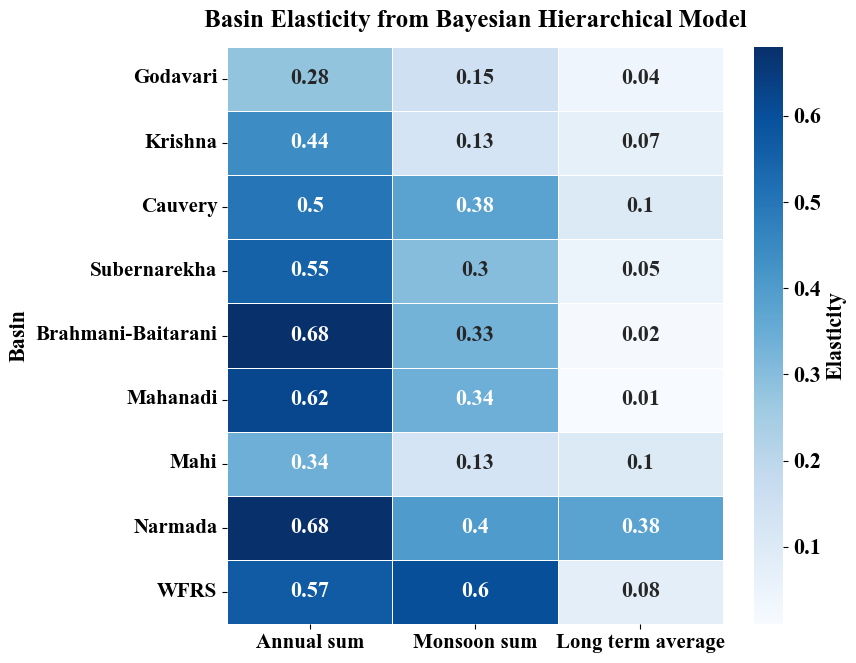

✅ Basin-level elasticity heatmap saved to C:\\Users\\User\\OneDrive - The University of Melbourne\\1 Poornima_Research_Work\\5 Elasticity\BH\Basin_Elasticity_Heatmap.png


In [8]:
import seaborn as sns
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------------------------------------------------------------
# Custom basin plotting order
# -----------------------------------------------------------------------------------
basins = [
    "Godavari",
    "Krishna",
    "Cauvery",
    "Subernarekha",
    "Brahmani-Baitarani",
    "Mahanadi",
    "Mahi",
    "Narmada",
    "Tapi",
    "WFRN",
    "WFRS",
    "EFRN",
    "EFRS"
]

# -----------------------------------------------------------------------------------
# Basin-level elasticity heatmap across Asum, Msum, ltm (ORDERED)
# -----------------------------------------------------------------------------------
def plot_basin_elasticity_heatmap(excel_path, sheet_names, tdims, save_dir, model_name):
    basin_elasticities = []

    # Extract basin mean elasticities from each sheet
    for sheet, tdim in zip(sheet_names, tdims):
        df = pd.read_excel(excel_path, sheet_name=sheet)
        df = df[~df['Basin'].str.lower().str.contains("efrs")]  # optional filter
        basin_means = df[['Basin', 'Basin_mean_epsilon (μ_ε)']].drop_duplicates()
        basin_means['TimeDim'] = tdim
        basin_elasticities.append(basin_means)

    # Combine into one dataframe
    all_means = pd.concat(basin_elasticities, ignore_index=True)

    # Pivot: rows = basins, columns = time dimensions
    heat_df = all_means.pivot(index="Basin", columns="TimeDim", values="Basin_mean_epsilon (μ_ε)")
    heat_df = heat_df.round(2)

    # ✅ Reorder basins according to the predefined list
    existing_basins = [b for b in basins if b in heat_df.index]
    heat_df = heat_df.loc[existing_basins]

    # ✅ Reorder columns according to tdims (to follow sheet order)
    heat_df = heat_df[tdims]

    # -----------------------------------------------------------------------------------
    # Plot heatmap
    # -----------------------------------------------------------------------------------
    plt.figure(figsize=(8, len(heat_df) * 0.5 + 3))
    cmap = plt.cm.get_cmap("Blues").copy()
    cmap.set_under("lightgrey")
    
    # ✅ Dynamically set colorbar limits from min to max of data
    vmin = heat_df.min().min()
    vmax = heat_df.max().max()
    
    ax = sns.heatmap(
        heat_df,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        annot=True,
        annot_kws={"weight": "bold", "fontsize": 16},
        linewidths=0.5,
        linecolor="white"
    )
    ax.set_title(f"Basin Elasticity from {model_name}", fontsize=18, fontweight="bold", x=0.5, y=1.02)
    # ax.set_xlabel("Time Dimension", fontsize=16, fontweight="bold")
    ax.set_ylabel("Basin", fontsize=16, fontweight="bold")
    ax.set_xlabel('')
    # Bold tick labels
    ax.tick_params(axis="both", labelsize=15)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight("bold")

    # --- Fix colorbar ---
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight("bold")
    cbar.set_label("Elasticity", fontsize=16, fontweight="bold")

    # Save
    out_path = os.path.join(save_dir, "Basin_Elasticity_Heatmap.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Basin-level elasticity heatmap saved to {out_path}")


# ---------------- Run ----------------
data_dir = r"C:\\Users\\User\\OneDrive - The University of Melbourne\\1 Poornima_Research_Work\\5 Elasticity"
save_dir = os.path.join(data_dir, "BH")
excel_path = os.path.join(data_dir, "elasticity_results.xlsx")
sheet_names = ["Asum", "Msum", "ltm"]
tdims = ["Annual sum", "Monsoon sum", "Long term average"]

plot_basin_elasticity_heatmap(
    excel_path,
    sheet_names,
    tdims,
    save_dir,
    model_name="Bayesian Hierarchical Model"
)


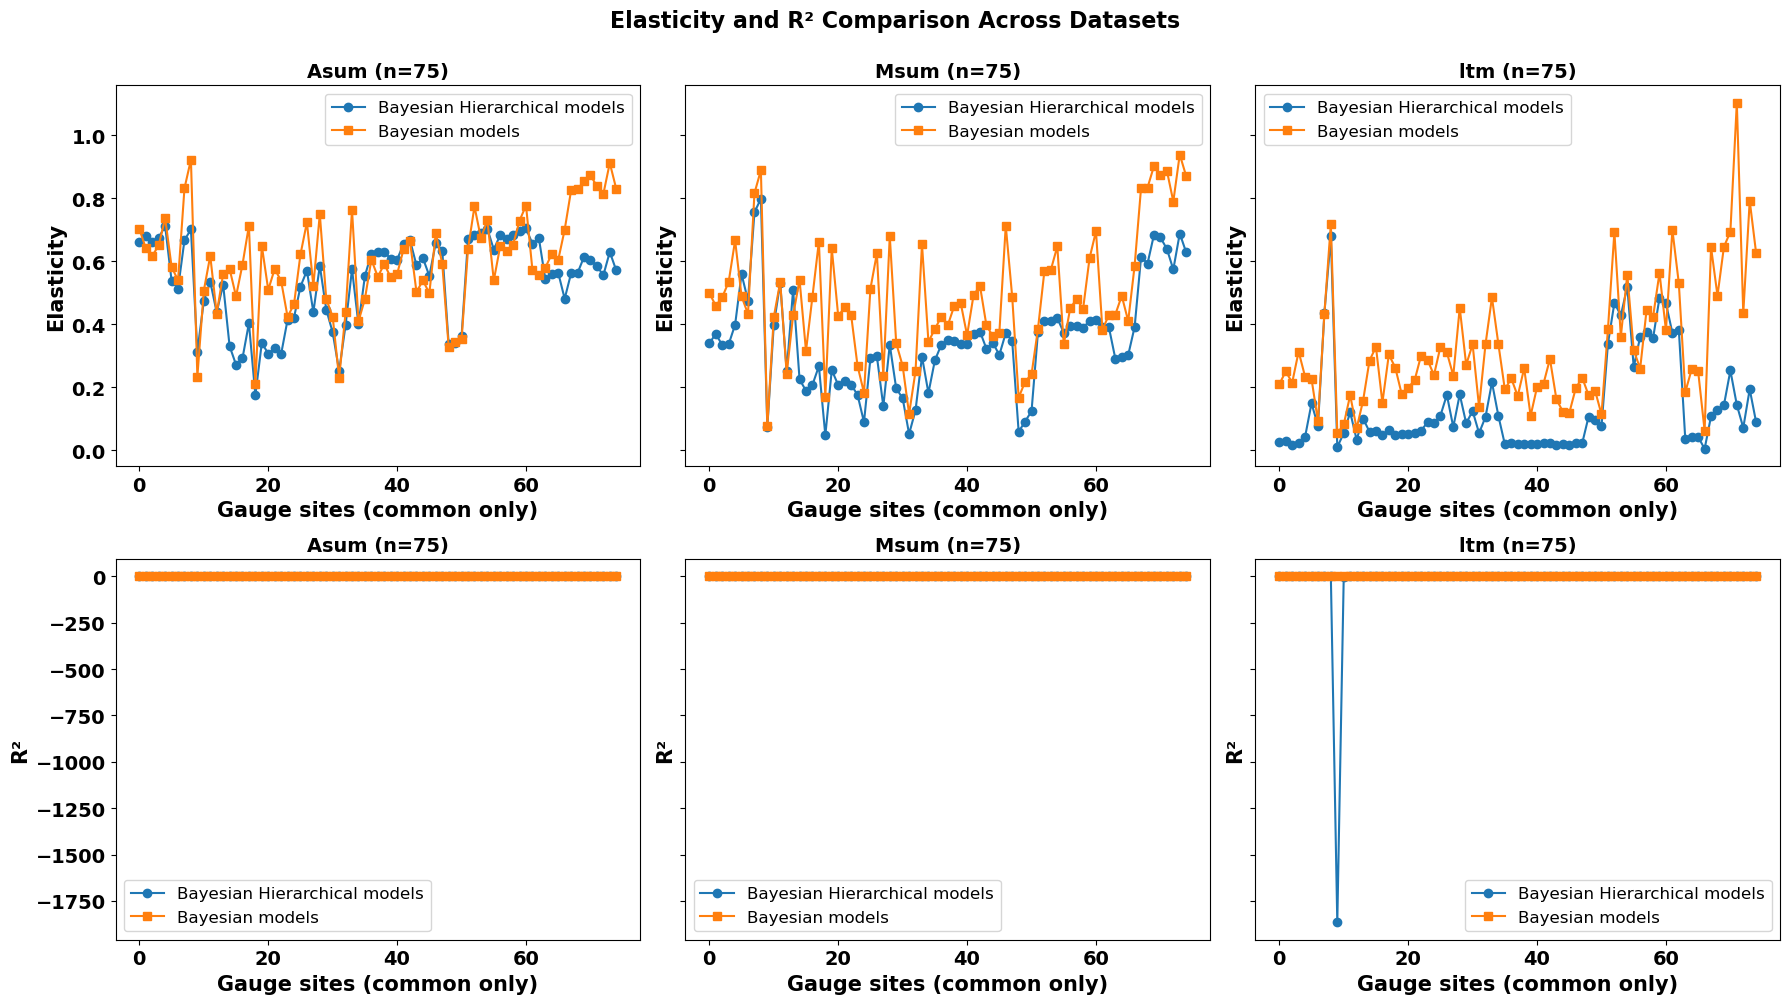

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt


data1_path = os.path.join(data_dir, "elasticity_results.xlsx")
data2_paths = {
    "Asum": os.path.join(data_dir, "traces_bayes\\ElasticityBM_AnnualSum.xlsx"),
    "Msum": os.path.join(data_dir, "traces_bayes\\ElasticityBM_Monsoon.xlsx"),
    "ltm":  os.path.join(data_dir, "traces_bayes\\ElasticityBM_LongTermMean.xlsx"),
}
sheet_names = ["Asum", "Msum", "ltm"]
save_dir = data_dir

# ---------------------------- Plot function ----------------------------
def plot_line_comparison(df1, df2, sheet, ax, value_col1, value_col2, ylabel, label1, label2):
    # Clean string columns
    df1['SubBasin'] = df1['SubBasin'].astype(str).str.strip()
    df2['gauge_id'] = df2['gauge_id'].astype(str).str.strip()
    
    # Merge on Gauge ID
    merged = pd.merge(df1, df2, left_on="SubBasin", right_on="gauge_id", how="inner")
    # ✅ Exclude 'Efrs' basin
    merged = merged[~merged['Basin'].str.lower().str.contains("efrs")]
    if merged.empty:
        ax.set_visible(False)
        return
    
    # Extract values
    x = range(len(merged))
    y1 = merged[value_col1]
    y2 = merged[value_col2]
    
    # Plot lines
    ax.plot(x, y1, marker="o", label=label1)
    ax.plot(x, y2, marker="s", label=label2)
    
    # Titles and labels
    ax.set_title(f"{sheet} (n={len(merged)})", fontsize=14, fontweight="bold")
    ax.set_xlabel("Gauge sites (common only)", fontsize=15, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=15, fontweight="bold")  # <-- added fontweight

    # Legend
    ax.legend(fontsize=12)

    # Tick labels
    ax.tick_params(axis='both', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')


# ---------------------------- Create figure with 2 rows ----------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey='row')

for i, sheet in enumerate(sheet_names):

    # Read data
    df1 = pd.read_excel(data1_path, sheet_name=sheet)
    df2 = pd.read_excel(data2_paths[sheet], sheet_name="Sheet1")
    
    # Top row: Elasticity
    plot_line_comparison(df1, df2, sheet, axes[0, i],
                         value_col1="Elasticity_epsilon (ε_s)",
                         value_col2="Elasticity",
                         ylabel="Elasticity",
                         label1="Bayesian Hierarchical models",
                         label2="Bayesian models")
    
    # Bottom row: R²
    plot_line_comparison(df1, df2, sheet, axes[1, i],
                         value_col1="R²",
                         value_col2="R2",
                         ylabel="R²",
                         label1="Bayesian Hierarchical models",
                         label2="Bayesian models")

plt.suptitle("Elasticity and R² Comparison Across Datasets", fontsize=16, fontweight="bold", x=0.5, y = 1)
plt.tight_layout(rect=[0, 0, 1, 1])

# Save figure
plt.savefig(os.path.join(save_dir, "elasticity_r2_compare.png"), dpi=300, bbox_inches="tight")
plt.show()
